In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pl
from scipy.stats import mode
from collections import Counter
import louvain
import seaborn as sns
import scipy.stats


def ReadTable(Infile):return pd.read_table(Infile,sep='\t',index_col=0)

/Users/huangbeibei/opt/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
#如果数据换了(细胞或者基因改变了，这个文件夹要删掉！！！不然会启用之前保存的，不会覆盖！！！)
sc.settings.verbosity = 3
sc.set_figure_params(color_map='viridis')
sc.logging.print_versions()
results_file = 'nestorowa.h5ad'
results_file_denoised = 'nestorowa_denoised.h5ad'

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.1.0 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.7.0


# 1、预处理得到相应细胞的Meta和Count文件

In [6]:
#用High variable gene count:
#CountF='IntegrateO7Y7_ScanpyNormLn_FilterCells_Singler_Variable2200_T.txt'
#CountDF=ReadTable(CountF)
#MF='IntegrateO7Y7_MetaData_processed_forSingler_removeNKp.txt'
#MDF=ReadTable(MF)
#len(MDF)
#MDF=MDF[MDF['CellType2']!='AdapativeNK_4']
#len(MDF)
#CountDF=CountDF.loc[list(MDF.index)]
#CountDF.to_csv('IntegrateO7Y7_ScanpyNormLn_FilterCells_Singler_Variable2200_T_removeNKp_removeNKT.txt',sep='\t')
#MDF.to_csv('IntegrateO7Y7_MetaData_processed_forSingler_removeNKp_removeNKT.txt',sep='\t')
#MF='IntegrateO7Y7_MetaData_processed_forSingler_removeNKp.txt'
#MDF=ReadTable(MF)
#len(MDF)


# 2、读入SC

In [3]:
# gene expression （行是细胞，列是基因）
adata = sc.read('IntegrateO7Y7_ScanpyNormLn_FilterCells_Singler_Variable2200_T_removeNKp_removeNKT.txt', cache=True)

# cell type annotation
cell_types = pd.read_csv('IntegrateO7Y7_MetaData_processed_forSingler_removeNKp_removeNKT.txt', sep='\t',index_col=0)
group_types = pd.read_csv('IntegrateO7Y7_MetaData_processed_forSingler_removeNKp_removeNKT.txt', sep='\t',index_col=0)
cellgroup_types = pd.read_csv('IntegrateO7Y7_MetaData_processed_forSingler_removeNKp_removeNKT.txt', sep='\t',index_col=0)
# replace with shorter names
acronyms1 = {'AdapativeNK_1': 'AdapativeNK_1', 'AdapativeNK_2': 'AdapativeNK_2', 'AdapativeNK_3': 'AdapativeNK_3',
            'Nkbright': 'Nkbright','MatureNK':'MatureNK'}
acronyms2 = {'O7': 'O7','Y7': 'Y7'}
acronyms3 = {'O7_AdapativeNK_1': 'O7_AdapativeNK_1', 'O7_AdapativeNK_2': 'O7_AdapativeNK_2', 'O7_AdapativeNK_3': 'O7_AdapativeNK_3',
            'O7_Nkbright': 'O7_Nkbright', 'O7_MatureNK': 'O7_MatureNK', 'Y7_AdapativeNK_1': 'Y7_AdapativeNK_1', 'Y7_AdapativeNK_2': 'Y7_AdapativeNK_2', 'Y7_AdapativeNK_3': 'Y7_AdapativeNK_3',
            'Y7_Nkbright': 'Y7_Nkbright','Y7_MatureNK': 'Y7_MatureNK'}

# add this cell type information
cell_types = [acronyms1[cell_types.loc[cell_id, 'CellType2']]
              if cell_id in cell_types.index else 'no_gate' for cell_id in adata.obs_names]
group_types = [acronyms2[group_types.loc[cell_id, 'orig.ident']]
              if cell_id in group_types.index else 'no_gate' for cell_id in adata.obs_names]
cellgroup_types = [acronyms3[cellgroup_types.loc[cell_id, 'CellType2Group']]
              if cell_id in cellgroup_types.index else 'no_gate' for cell_id in adata.obs_names]
#color_types = [acronyms3[color_types.loc[cell_id, 'color']]
              #if cell_id in color_types.index else 'no_gate' for cell_id in adata.obs_names]
adata.obs['CellType'] = cell_types
adata.obs['Group'] = group_types
adata.obs['CellTypeGroup'] = cellgroup_types


... reading from cache file cache/IntegrateO7Y7_ScanpyNormLn_FilterCells_Singler_Variable2200_T_removeNKp_removeNKT.h5ad


In [4]:
adata

AnnData object with n_obs × n_vars = 11326 × 2200
    obs: 'CellType', 'Group', 'CellTypeGroup'

In [5]:
adata.raw = adata
#sc.pp.recipe_weinreb17(adata, log=False)
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:01)


computing neighbors
    using 'X_pca' with n_pcs = 25
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:12)


/Users/huangbeibei/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'CellType' as categorical
... storing 'Group' as categorical
... storing 'CellTypeGroup' as categorical


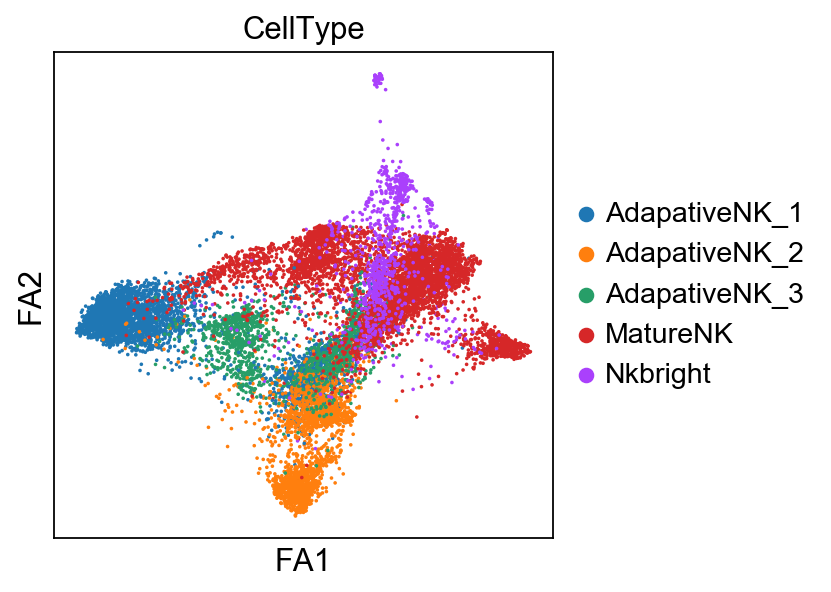

In [6]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=25)
sc.tl.draw_graph(adata, layout='fa', random_state=3)
sc.pl.draw_graph(adata, color='CellType', layout='fa')

# PAGA

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


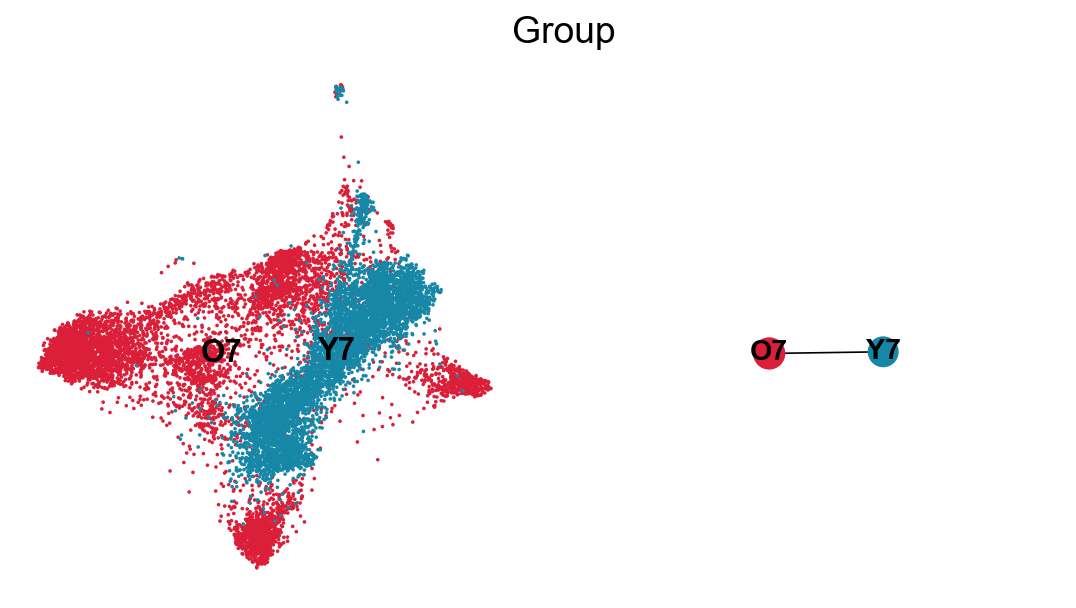

--> added 'pos', the PAGA positions (adata.uns['paga'])


<Figure size 320x320 with 0 Axes>

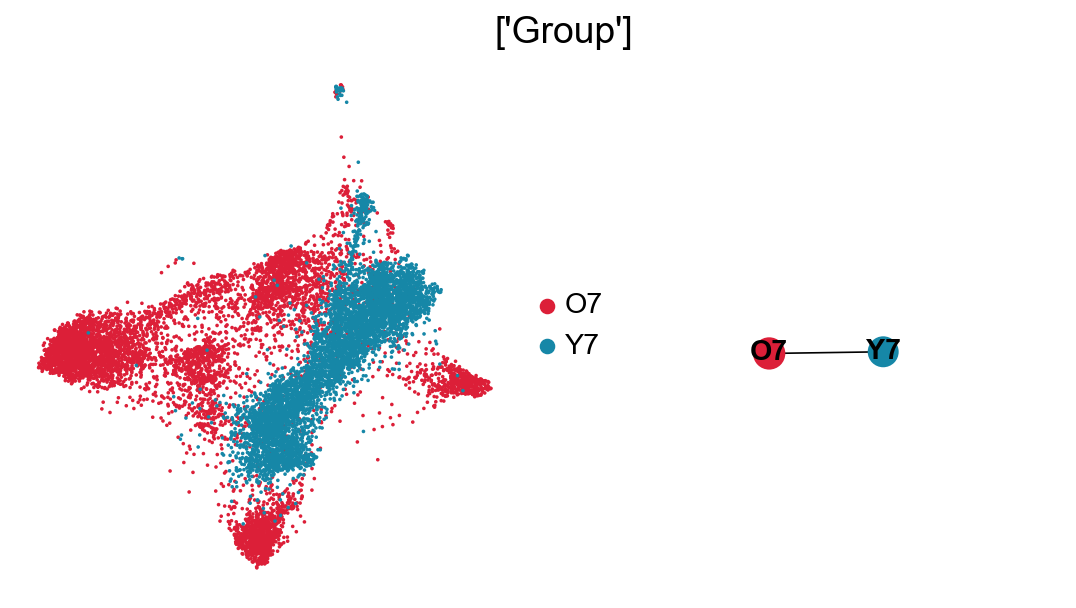

In [10]:
sc.tl.paga(adata, groups='Group')
sc.pl.paga_compare(adata, basis='X_draw_graph_fa')
from matplotlib import rcParams
import matplotlib.pyplot as plt
fig = plt.figure()
ax = sc.pl.paga_compare(adata, basis='X_draw_graph_fa', color=['Group'], legend_loc='right margin'
                        ,palette=('#dc1f38','#1687a7')
                        ,save='PAGA_O7Y7_Group.pdf')

pl.show()

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


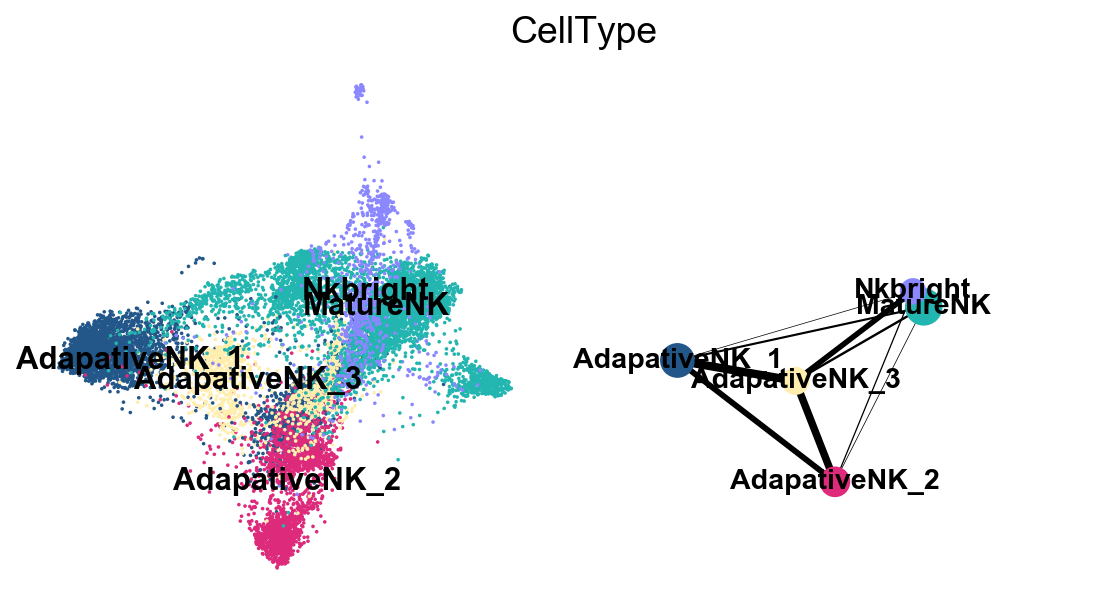

--> added 'pos', the PAGA positions (adata.uns['paga'])


<Figure size 320x320 with 0 Axes>

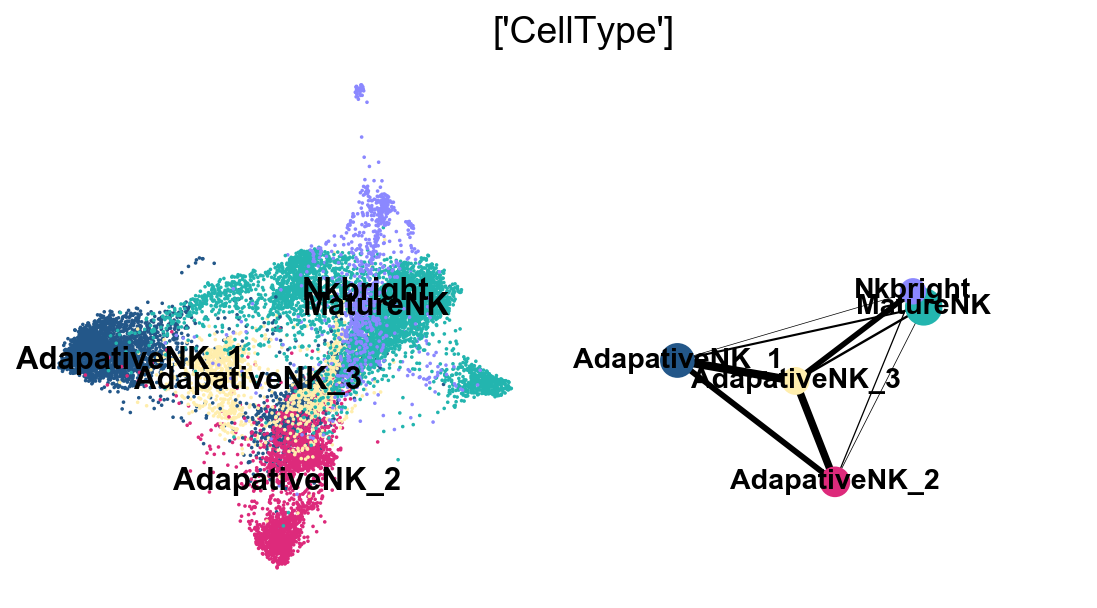

In [12]:
sc.tl.paga(adata, groups='CellType')
sc.pl.paga_compare(adata, basis='X_draw_graph_fa')
from matplotlib import rcParams
import matplotlib.pyplot as plt
fig = plt.figure()
sc.pl.paga_compare(adata, basis='X_draw_graph_fa', color=['CellType'], legend_loc='on data'
                        ,palette=('#235789','#dd2a7b','#ffeead','#23B5AF','#8B88FF')
                        ,save='PAGA_O7Y7_CellType.pdf')

pl.show()

In [13]:
adata_O7=adata[adata.obs['Group']=='O7',:]
adata_Y7=adata[adata.obs['Group']=='Y7',:]

/Users/huangbeibei/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


running PAGA


Trying to set attribute `.uns` of view, copying.


    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


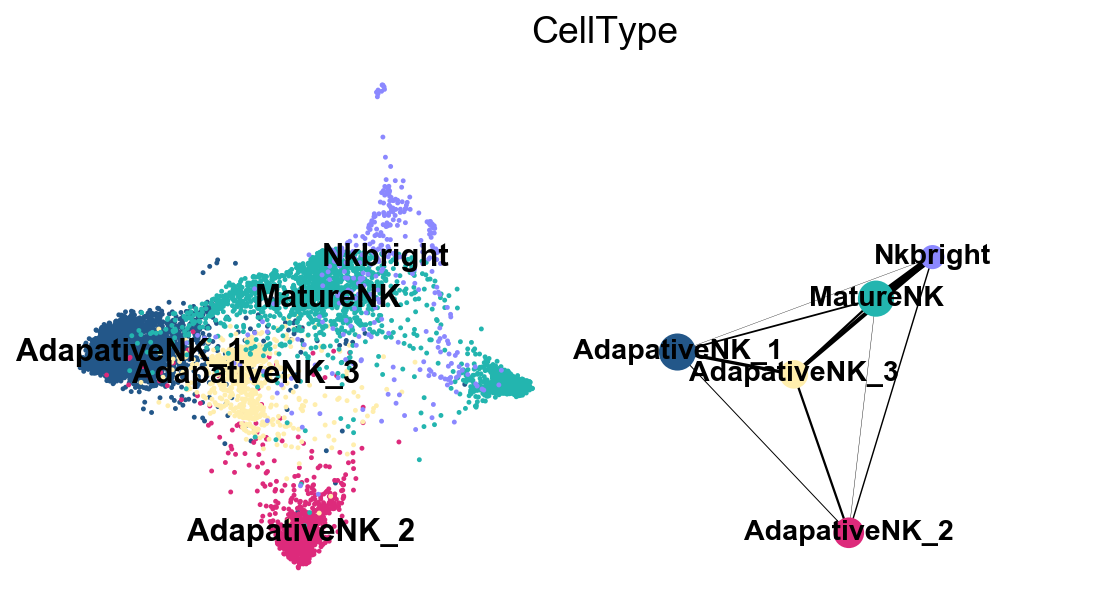

--> added 'pos', the PAGA positions (adata.uns['paga'])


<Figure size 320x320 with 0 Axes>

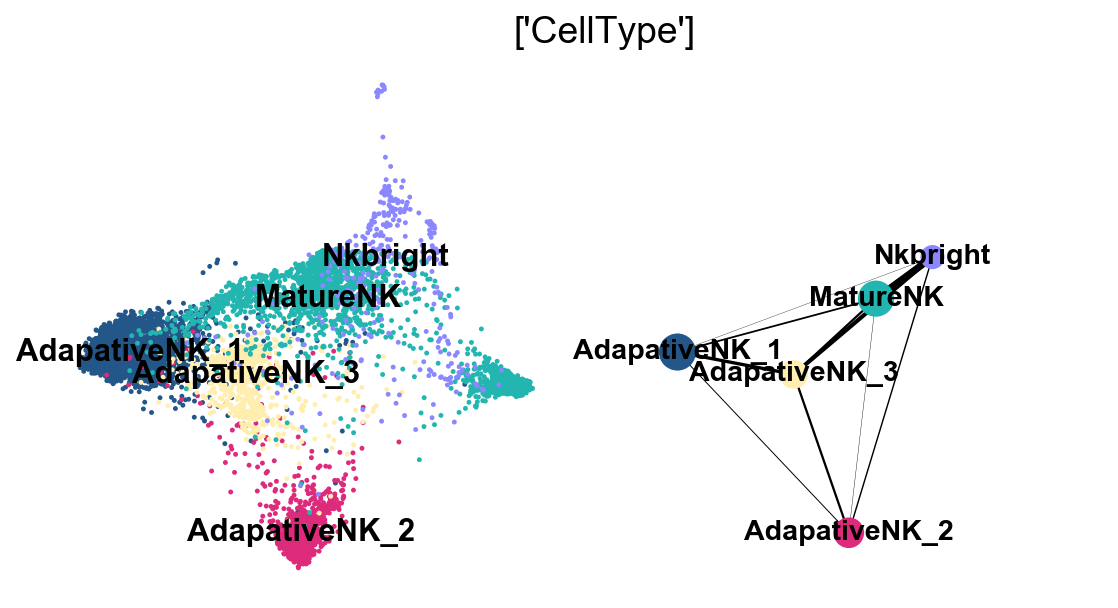

In [14]:
#O7
sc.tl.paga(adata_O7, groups='CellType')
sc.pl.paga_compare(adata_O7, basis='X_draw_graph_fa')
from matplotlib import rcParams
import matplotlib.pyplot as plt
fig = plt.figure()
sc.pl.paga_compare(adata_O7, basis='X_draw_graph_fa', color=['CellType'], legend_loc='on data'
                        ,palette=('#235789','#dd2a7b','#ffeead','#23B5AF','#8B88FF')
                        ,save='PAGA_O7_CellType.pdf')

pl.show()

running PAGA


Trying to set attribute `.uns` of view, copying.


    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


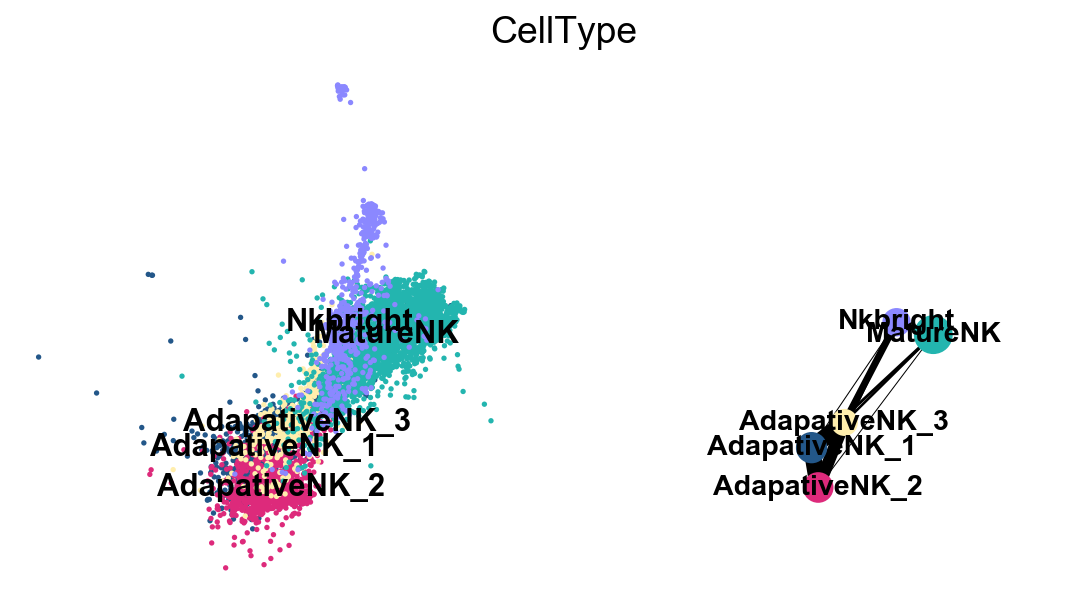

--> added 'pos', the PAGA positions (adata.uns['paga'])


<Figure size 320x320 with 0 Axes>

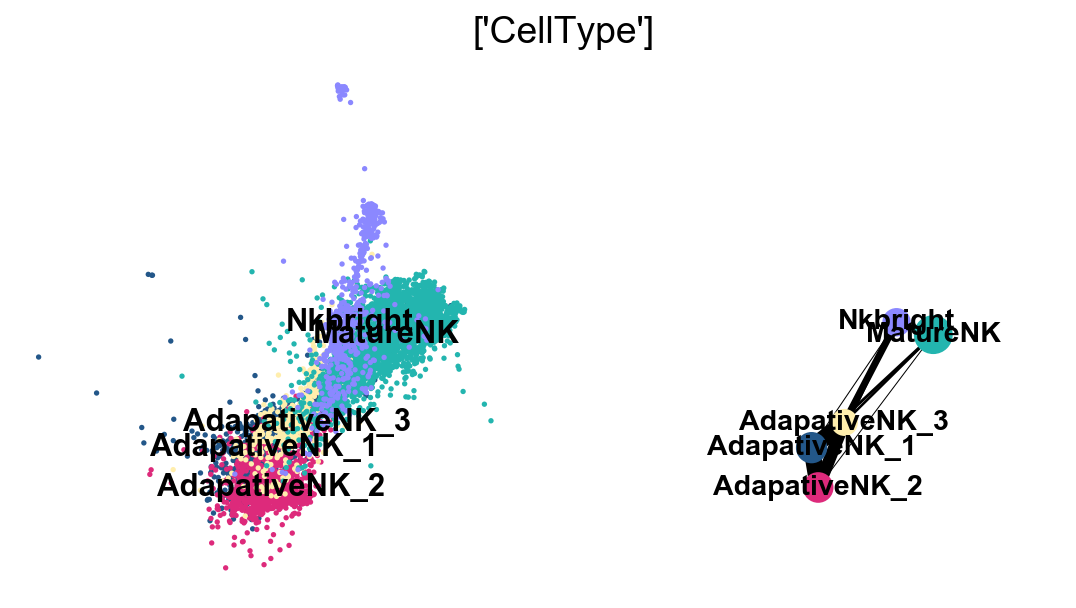

In [15]:
#Y7
sc.tl.paga(adata_Y7, groups='CellType')
sc.pl.paga_compare(adata_Y7, basis='X_draw_graph_fa')
from matplotlib import rcParams
import matplotlib.pyplot as plt
fig = plt.figure()
sc.pl.paga_compare(adata_Y7, basis='X_draw_graph_fa', color=['CellType'], legend_loc='on data'
                        ,palette=('#235789','#dd2a7b','#ffeead','#23B5AF','#8B88FF')
                        ,save='PAGA_Y7_CellType.pdf')

pl.show()

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


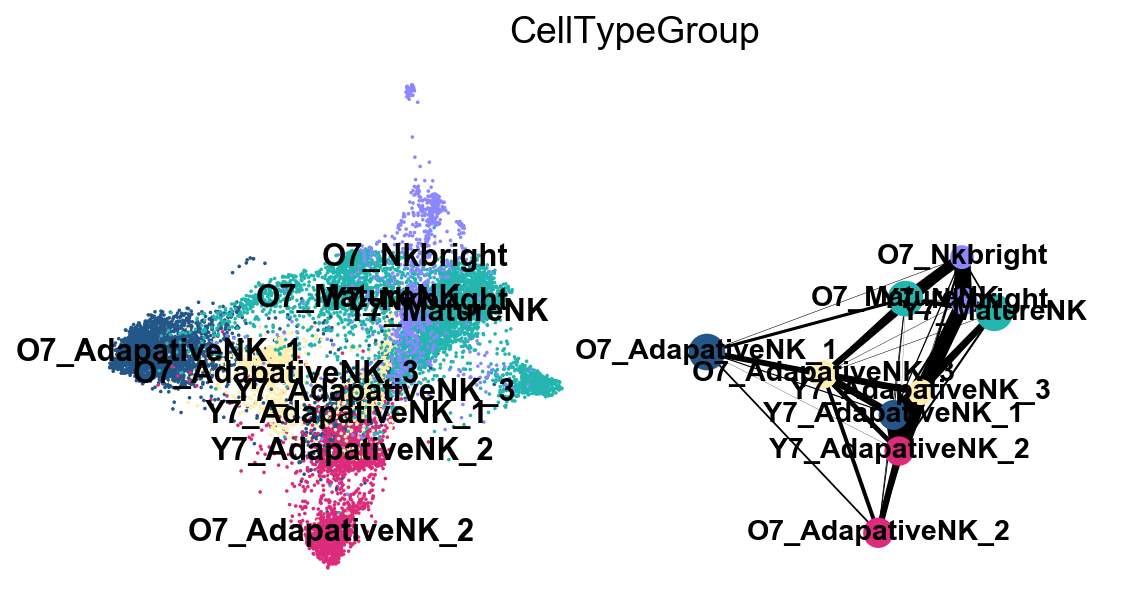

--> added 'pos', the PAGA positions (adata.uns['paga'])


<Figure size 320x320 with 0 Axes>

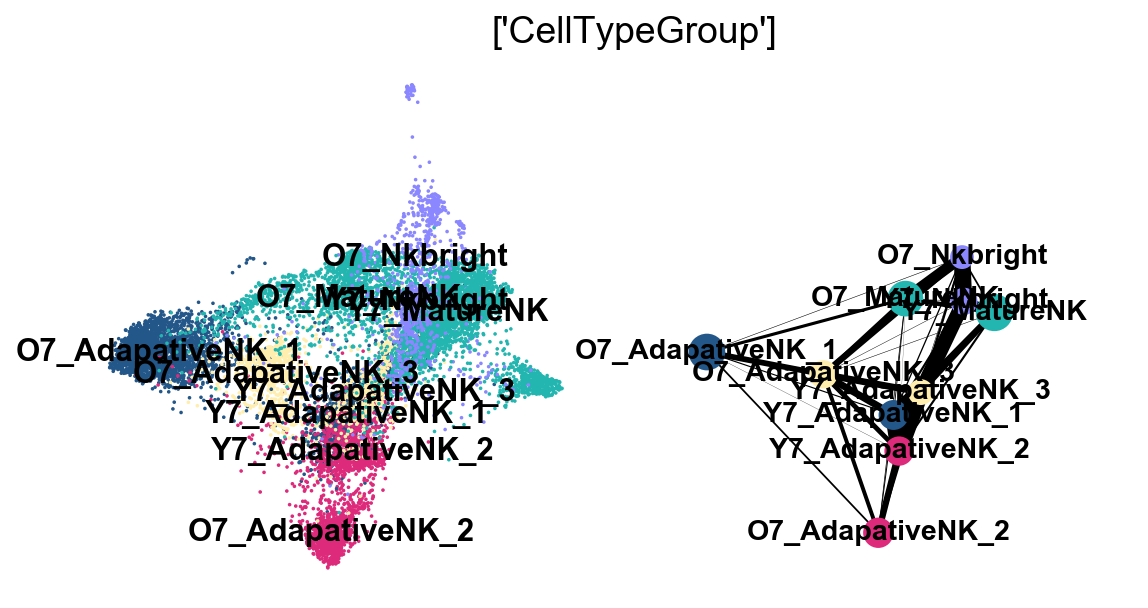

In [17]:
sc.tl.paga(adata, groups='CellTypeGroup')
sc.pl.paga_compare(adata, basis='X_draw_graph_fa')
from matplotlib import rcParams
import matplotlib.pyplot as plt
fig = plt.figure()
sc.pl.paga_compare(adata, basis='X_draw_graph_fa', color=['CellTypeGroup'], legend_loc='on data'
                        ,palette=('#235789','#dd2a7b','#ffeead','#23B5AF','#8B88FF','#235789','#dd2a7b','#ffeead','#23B5AF','#8B88FF')
                        ,save='PAGA_O7Y7_CellTypeGroup.pdf')

pl.show()